In [ ]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats

# File paths
# finetuned_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_eval_qwen3_4b_test.jsonl'

finetuned_article_v2_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_eval_qwen3_4b_test_gpt5_instruct_article_lora_fixed_v2.jsonl'
finetuned_article_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_eval_qwen3_4b_test_gpt5_instruct_article_lora_fixed.jsonl'
finetuned_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_eval_qwen3_4b_test_gpt5_instruct_lora_fixed.jsonl'
original_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/original_eval_qwen3_4b_test.jsonl'
base_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/baseline_eval_qwen3_4b_test.jsonl'
gpt5_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/eval_gpt5_test.jsonl'

def parse_scores(explanation):
    """
    Parse scores from explanation text, handling different formats:
    - "Faithfulness (78/100):"
    - "Faithfulness: 78/100"
    - "Faithfulness (78):"
    - "Faithfulness (0-100): 92"
    - "Faithfulness (accuracy to the paper): 95/100"
    - "Overall (82/100):"
    """
    scores = {}
    
    if not explanation or not isinstance(explanation, str):
        return scores
    
    # Dimensions to extract
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for dim in dimensions:
        # Try different patterns - order matters (more specific first)
        patterns = [
            # Formats with "score:" keyword
            rf'{dim}\s+score:\s*(\d+)/100',               # "Faithfulness score: 5/100"
            rf'{dim}\s+score:\s*(\d+)',                   # "Faithfulness score: 5"
            
            # Standard formats with parentheses and /100
            rf'{dim}\s*\((\d+)/100\)',                    # "Faithfulness (78/100):"
            rf'{dim}\s*\([^)]*\):\s*(\d+)/100',           # "Faithfulness (accuracy to the paper): 95/100"
            rf'{dim}\s*\([^)]*\):\s*(\d+)',               # "Faithfulness (0-100): 92"
            rf'{dim}\s*\((\d+)\)',                        # "Faithfulness (78):"
            
            # Formats with colon
            rf'{dim}:\s*(\d+)/100',                       # "Faithfulness: 78/100"
            rf'{dim}:\s*(\d+)',                           # "Faithfulness: 78"
            
            # Formats with space
            rf'{dim}\s+(\d+)/100',                        # "Faithfulness 78/100"
            rf'{dim}\s+(\d+)',                            # "Faithfulness 78"
            
            # Formats with dash
            rf'{dim}\s*[–-]\s*(\d+)/100',                 # "Faithfulness - 78/100"
            rf'{dim}\s*[–-]\s*(\d+)',                     # "Faithfulness - 78"
            
            # Look for score on next line after dimension header
            rf'{dim}\s*\([^)]*\):\s*\n\s*(\d+)/100',      # "Faithfulness (...):\n78/100"
            rf'{dim}\s*\([^)]*\):\s*\n\s*(\d+)',          # "Faithfulness (...):\n78"
        ]
        
        for pattern in patterns:
            match = re.search(pattern, explanation, re.IGNORECASE | re.MULTILINE)
            if match:
                try:
                    score = int(match.group(1))
                    # Validate score is in reasonable range
                    if 0 <= score <= 100:
                        scores[dim] = score
                        break
                except (ValueError, IndexError):
                    continue
    
    return scores

def load_eval_results(filepath):
    """Load evaluation results from JSONL file"""
    results = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data = json.loads(line)
                scores = parse_scores(data.get('explanation', ''))
                results.append({
                    'index': data.get('index', len(results)),
                    'judgment': data.get('judgment', ''),
                    'scores': scores,
                    'explanation': data.get('explanation', '')
                })
    return results

# Load all results
print("Loading evaluation results...")
original_results = load_eval_results(original_eval)
gpt5_results = load_eval_results(gpt5_eval)
base_results = load_eval_results(base_eval)
finetuned_results = load_eval_results(finetuned_eval)
finetuned_article_results = load_eval_results(finetuned_article_eval)
finetuned_article_v2_results = load_eval_results(finetuned_article_v2_eval)

print(f"Loaded {len(original_results)} original results")
print(f"Loaded {len(gpt5_results)} gpt5 results")
print(f"Loaded {len(base_results)} baseline results")
print(f"Loaded {len(finetuned_results)} fine-tuned results")
print(f"Loaded {len(finetuned_article_results)} fine-tuned article results")
print(f"Loaded {len(finetuned_article_v2_results)} fine-tuned article v2 results")

# Create comparison DataFrame
def create_comparison_df(results_list, names):
    """Create a comparison DataFrame from multiple result sets"""
    all_data = []
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for idx in range(len(results_list[0])):
        row = {'index': idx}
        for i, (results, name) in enumerate(zip(results_list, names)):
            if idx < len(results):
                result = results[idx]
                row[f'{name}_judgment'] = result['judgment']
                for dim in dimensions:
                    score = result['scores'].get(dim, np.nan)
                    row[f'{name}_{dim}'] = score
        all_data.append(row)
    
    return pd.DataFrame(all_data)

# Create comparison DataFrame - order: original, gpt5, baseline, finetuned, finetuned_article, finetuned_article_v2
comparison_df = create_comparison_df(
    [original_results, gpt5_results, base_results, finetuned_results, finetuned_article_results, finetuned_article_v2_results],
    ['original', 'gpt5', 'base', 'finetuned', 'finetuned_article', 'finetuned_article_v2']
)

print("\nComparison DataFrame created!")
print(f"Shape: {comparison_df.shape}")
print("\nFirst few rows:")
print(comparison_df.head())


Loading evaluation results...
Loaded 1000 original results
Loaded 1000 gpt5 results
Loaded 1000 baseline results
Loaded 1000 fine-tuned results
Loaded 1000 fine-tuned article results
Loaded 1000 fine-tuned article v2 results

Comparison DataFrame created!
Shape: (1000, 43)

First few rows:
   index original_judgment  original_Faithfulness  original_Coverage  \
0      0               Yes                   95.0               80.0   
1      1               Yes                   90.0               78.0   
2      2                No                   88.0               72.0   
3      3               Yes                   92.0               84.0   
4      4               Yes                   95.0               78.0   

   original_Clarity  original_Conciseness  original_Coherence  \
0              90.0                  96.0                94.0   
1              90.0                  95.0                90.0   
2              74.0                  45.0                50.0   
3              8

In [2]:
# Debug: Find entries with missing scores
def find_missing_scores(results_list, names):
    """Find entries where scores are missing"""
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for results, name in zip(results_list, names):
        missing_count = 0
        missing_examples = []
        
        for idx, result in enumerate(results):
            scores = result['scores']
            missing_dims = [dim for dim in dimensions if dim not in scores]
            
            if missing_dims:
                missing_count += 1
                if len(missing_examples) < 5:  # Show first 5 examples
                    missing_examples.append({
                        'index': result['index'],
                        'missing_dims': missing_dims,
                        'explanation_preview': result['explanation'][:200] if result['explanation'] else 'No explanation',
                        'judgment': result['judgment']
                    })
        
        print(f"\n{name.upper()} - Missing scores in {missing_count}/{len(results)} entries")
        if missing_examples:
            print("\nSample entries with missing scores:")
            for ex in missing_examples:
                print(f"  Index {ex['index']}: Missing {ex['missing_dims']}")
                print(f"    Judgment: {ex['judgment']}")
                print(f"    Explanation preview: {ex['explanation_preview']}...")
                print()

find_missing_scores([original_results, gpt5_results, base_results, finetuned_results, finetuned_article_results, finetuned_article_v2_results], 
                    ['original', 'gpt5', 'base', 'finetuned', 'finetuned_article', 'finetuned_article_v2'])



ORIGINAL - Missing scores in 26/1000 entries

Sample entries with missing scores:
  Index 22: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    Judgment: No
    Explanation preview: Faithfulness (Score: 45)
- The summary introduces claims not supported by the provided text, notably: “two types of models have this property: scalar fields with unconventional kinetic term and models...

  Index 42: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    Judgment: Yes
    Explanation preview: Faithfulness (score: 92)
- The summary accurately reflects the paper’s central claims: (i) the Isham–Storey solution with the Isham–Salam–Strathdee potential is not a regular black hole because of hor...

  Index 51: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence']
    Judgment: Yes
    Explanation preview: Faithfulness (Score: 92)
- The summary accurately reflects the paper’s content. It correctly 

In [3]:
comparison_df.columns

Index(['index', 'original_judgment', 'original_Faithfulness',
       'original_Coverage', 'original_Clarity', 'original_Conciseness',
       'original_Coherence', 'original_Overall', 'gpt5_judgment',
       'gpt5_Faithfulness', 'gpt5_Coverage', 'gpt5_Clarity',
       'gpt5_Conciseness', 'gpt5_Coherence', 'gpt5_Overall', 'base_judgment',
       'base_Faithfulness', 'base_Coverage', 'base_Clarity',
       'base_Conciseness', 'base_Coherence', 'base_Overall',
       'finetuned_judgment', 'finetuned_Faithfulness', 'finetuned_Coverage',
       'finetuned_Clarity', 'finetuned_Conciseness', 'finetuned_Coherence',
       'finetuned_Overall', 'finetuned_article_judgment',
       'finetuned_article_Faithfulness', 'finetuned_article_Coverage',
       'finetuned_article_Clarity', 'finetuned_article_Conciseness',
       'finetuned_article_Coherence', 'finetuned_article_Overall',
       'finetuned_article_v2_judgment', 'finetuned_article_v2_Faithfulness',
       'finetuned_article_v2_Coverage', 'fin

In [4]:
comparison_df[['original_judgment', 'gpt5_judgment', 'base_judgment', 'finetuned_judgment', 'finetuned_article_judgment', 'finetuned_article_v2_judgment']].head(10)

,original_judgment,gpt5_judgment,base_judgment,finetuned_judgment,finetuned_article_judgment,finetuned_article_v2_judgment
0,Yes,Yes,Yes,Yes,No,Yes
1,Yes,Yes,Yes,Yes,Yes,Yes
2,No,Yes,Yes,Yes,Yes,No
3,Yes,Yes,Yes,No,No,No
4,Yes,Yes,No,No,No,No
5,Yes,Yes,Yes,No,Yes,No
6,Yes,No,No,No,No,No
7,No,Yes,No,Yes,No,Yes
8,Yes,Yes,No,No,Yes,Yes
9,No,Yes,Yes,No,No,No


In [5]:
comparison_df[['original_Overall', 'gpt5_Overall', 'base_Overall', 'finetuned_Overall', 'finetuned_article_Overall', 'finetuned_article_v2_Overall']].head(10)

,original_Overall,gpt5_Overall,base_Overall,finetuned_Overall,finetuned_article_Overall,finetuned_article_v2_Overall
0,91.0,95,94.0,82.0,77.0,90.0
1,88.0,96,88.0,79.0,89.0,90.0
2,62.0,92,92.0,84.0,93.0,74.0
3,87.0,94,90.0,50.0,75.0,72.0
4,88.0,93,72.0,33.0,60.0,45.0
5,85.0,93,88.0,10.0,82.0,44.0
6,88.0,84,68.0,36.0,60.0,78.0
7,70.0,93,77.0,84.0,72.0,88.0
8,91.0,93,78.0,11.0,86.0,88.0
9,65.0,94,88.0,42.0,80.0,78.0


# Yes/No judgment comparison

In [6]:
dimensions = ['Overall', 'Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence']
models = ['original', 'gpt5', 'base', 'finetuned', 'finetuned_article', 'finetuned_article_v2']

In [7]:

print("Judgment (Yes/No) Comparison:")
print("=" * 80)

judgment_counts = {}
for model in models:
    col = f'{model}_judgment'
    if col in comparison_df.columns:
        counts = comparison_df[col].value_counts()
        judgment_counts[model] = counts
        print(f"\n{model.upper()}:")
        print(counts)
        if len(counts) > 0:
            yes_pct = (counts.get('Yes', 0) / len(comparison_df[col].dropna()) * 100) if len(comparison_df[col].dropna()) > 0 else 0
            print(f"  Yes: {yes_pct:.1f}%")

# Create judgment comparison DataFrame
judgment_df = pd.DataFrame(judgment_counts).fillna(0)
# Reorder columns to match desired order: original, gpt5, base, finetuned, finetuned_article, finetuned_article_v2
judgment_df = judgment_df.reindex(columns=models)
print("\n\nJudgment Counts Table:")
print(judgment_df)


Judgment (Yes/No) Comparison:

ORIGINAL:
original_judgment
Yes    748
No     252
Name: count, dtype: int64
  Yes: 74.8%

GPT5:
gpt5_judgment
Yes    991
No       9
Name: count, dtype: int64
  Yes: 99.1%

BASE:
base_judgment
No     503
Yes    497
Name: count, dtype: int64
  Yes: 49.7%

FINETUNED:
finetuned_judgment
No     930
Yes     70
Name: count, dtype: int64
  Yes: 7.0%

FINETUNED_ARTICLE:
finetuned_article_judgment
No     749
Yes    251
Name: count, dtype: int64
  Yes: 25.1%

FINETUNED_ARTICLE_V2:
finetuned_article_v2_judgment
No     699
Yes    301
Name: count, dtype: int64
  Yes: 30.1%


Judgment Counts Table:
     original  gpt5  base  finetuned  finetuned_article  finetuned_article_v2
No        252     9   503        930                749                   699
Yes       748   991   497         70                251                   301


# Calculate summary statistics

In [8]:
summary_stats = []
for dim in dimensions:
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna()
            if len(scores) > 0:
                mean = scores.mean()
                std = scores.std()
                n = len(scores)
                
                # Calculate 95% confidence interval
                if n > 1:
                    se = std / np.sqrt(n)
                    t_critical = stats.t.ppf(0.975, df=n-1)  # 95% CI
                    ci_lower = mean - t_critical * se
                    ci_upper = mean + t_critical * se
                else:
                    ci_lower = mean
                    ci_upper = mean
                
                summary_stats.append({
                    'Dimension': dim,
                    'Model': model,
                    'Mean[CI lower, CI upper]': f"{mean.round(1)} [{ci_lower.round(1)}, {ci_upper.round(1)}]",
                    'Std': std.round(1),
                    'Min': scores.min().round(1),
                    'Max': scores.max().round(1),
                    'Median': scores.median().round(1),
                    'Count': n
                })

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics by Dimension and Model:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Print in tab-separated format for easy copy-paste into Google Docs
print("\n\n" + "=" * 80)
print("COPY-PASTE FORMAT (Tab-separated for Google Docs):")
print("=" * 80)
print(summary_df.to_csv(sep='\t', index=False))

# Pivot for easier comparison
pivot_mean = summary_df.pivot(index='Dimension', columns='Model', values='Mean[CI lower, CI upper]')
# Reorder columns to match desired order: original, gpt5, base, finetuned, finetuned_article, finetuned_article_v2
pivot_mean = pivot_mean.reindex(columns=models)
print("\n\nMean Scores Comparison:")
print("=" * 80)
print(pivot_mean.round(2))

# Calculate improvements
print("\n\nFine-tuned vs Baseline Improvements:")
print("=" * 80)
improvements = []
for dim in dimensions:
    base_col = f'base_{dim}'
    finetuned_col = f'finetuned_{dim}'
    if base_col in comparison_df.columns and finetuned_col in comparison_df.columns:
        base_mean = comparison_df[base_col].mean()
        finetuned_mean = comparison_df[finetuned_col].mean()
        improvement = finetuned_mean - base_mean
        improvement_pct = (improvement / base_mean * 100) if base_mean > 0 else 0
        improvements.append({
            'Dimension': dim,
            'Baseline': base_mean,
            'Fine-tuned': finetuned_mean,
            'Improvement': improvement,
            'Improvement %': improvement_pct
        })

improvements_df = pd.DataFrame(improvements)
print(improvements_df.round(2).to_string(index=False))


Summary Statistics by Dimension and Model:
   Dimension                Model Mean[CI lower, CI upper]  Std  Min   Max  Median  Count
     Overall             original        82.4 [81.8, 83.0]  9.6 45.0  93.0    86.0    981
     Overall                 gpt5        93.6 [93.5, 93.7]  1.8 75.0  98.0    94.0   1000
     Overall                 base        82.2 [81.5, 82.9] 10.7 42.0  95.0    88.0    950
     Overall            finetuned        38.8 [37.3, 40.4] 24.1  0.0  93.0    40.0    957
     Overall    finetuned_article        70.8 [69.9, 71.6] 13.3 20.0  95.0    68.0    975
     Overall finetuned_article_v2        72.6 [71.8, 73.4] 13.1 10.0  95.0    68.0    979
Faithfulness             original        83.2 [82.3, 84.1] 14.6 30.0  98.0    90.0    974
Faithfulness                 gpt5        94.1 [93.9, 94.4]  3.9 55.0 100.0    95.0   1000
Faithfulness                 base        71.6 [70.3, 72.9] 19.7 10.0  97.0    78.0    926
Faithfulness            finetuned        32.0 [30.4, 33.6

# Visualizations


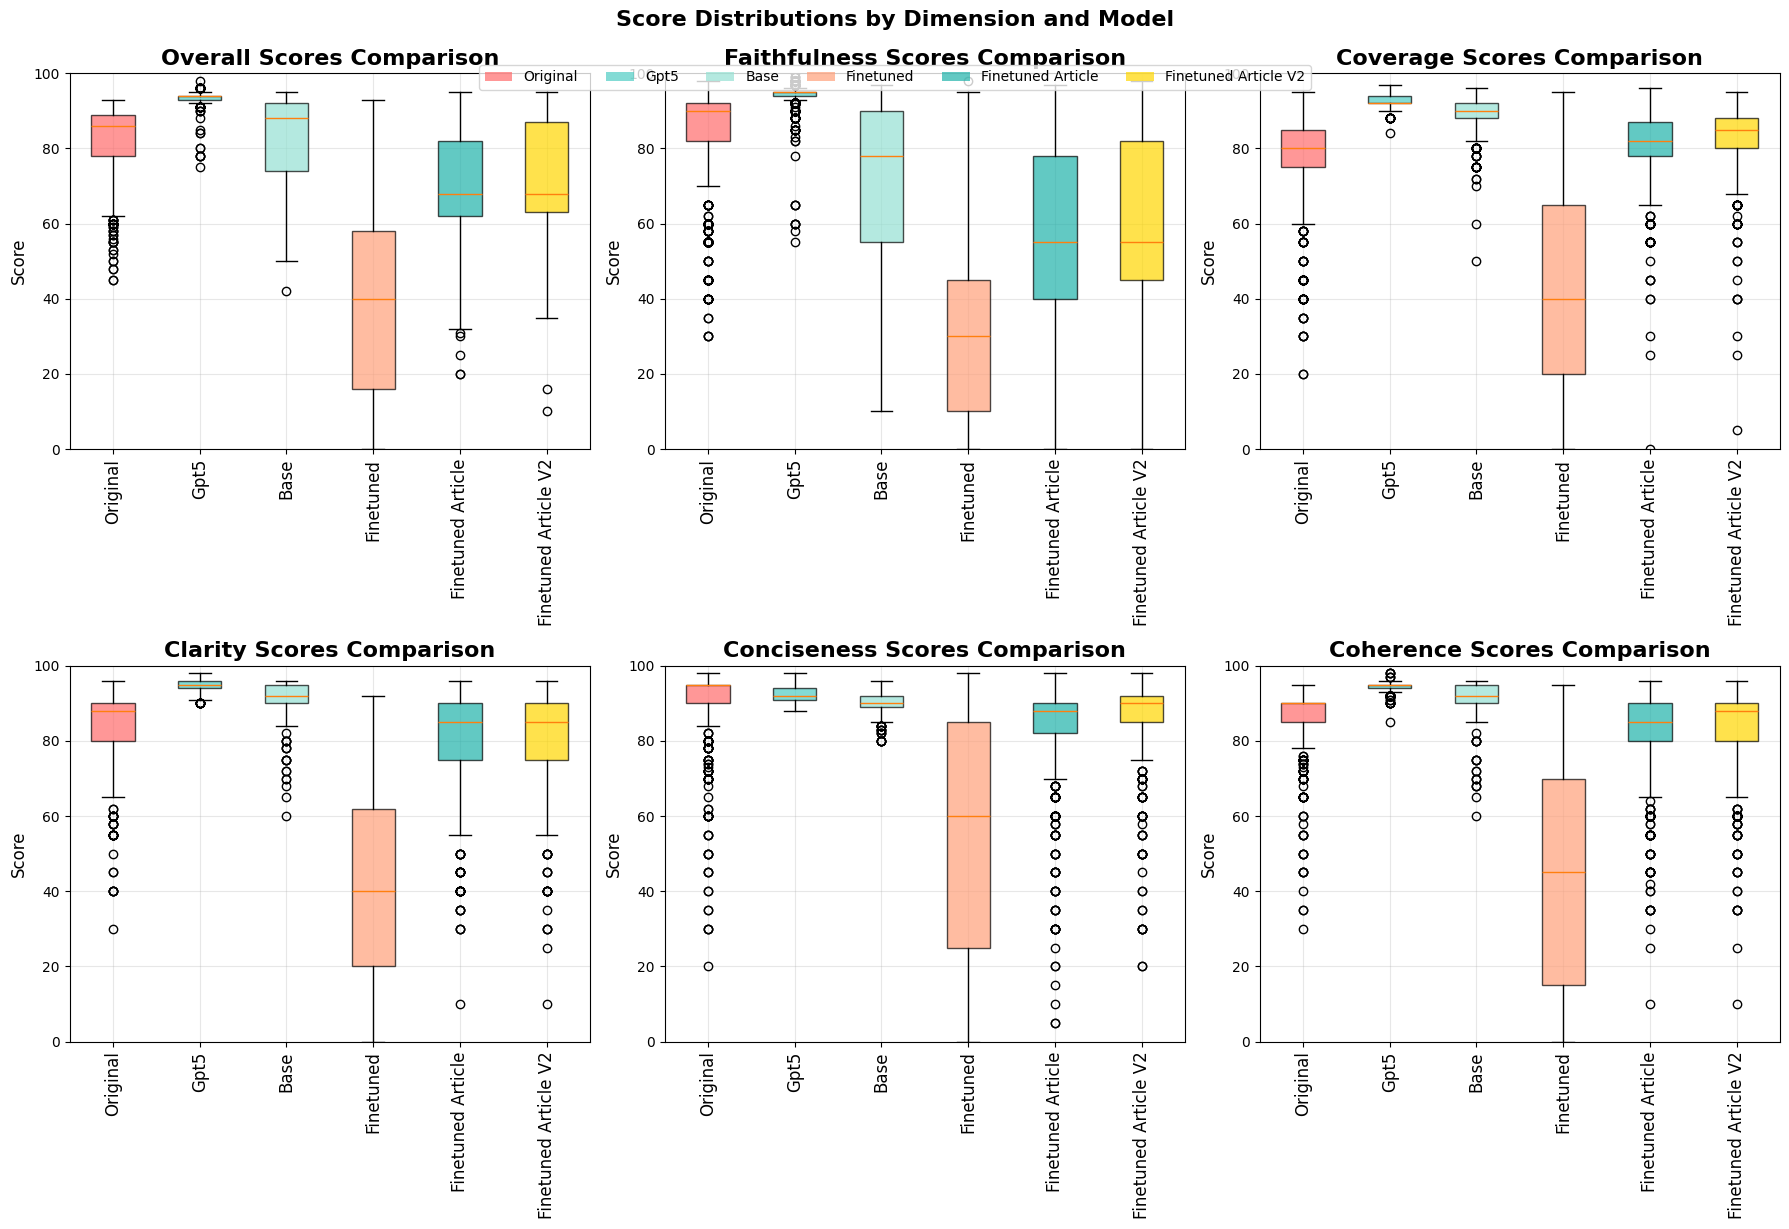

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define colors for each model
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A', '#20B2AA', '#FFD700']
model_colors = dict(zip(models, colors))

for idx, dim in enumerate(dimensions):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna().tolist()
            if scores:
                data_to_plot.append(scores)
                # Format label: replace underscores with spaces and capitalize each word
                label = ' '.join(word.capitalize() for word in model.split('_'))
                labels.append(label)
    
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)
        
        # Color the boxes
        for i, patch in enumerate(bp['boxes']):
            if i < len(colors):
                patch.set_facecolor(colors[i])
                patch.set_alpha(0.7)
        
        ax.set_title(f'{dim} Scores Comparison', fontsize=16, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        
        # Rotate x-axis labels vertically and increase font size
        ax.tick_params(axis='x', rotation=90, labelsize=12)

# Create legend handles
from matplotlib.patches import Patch
legend_handles = []
for model in models:
    # Format label: replace underscores with spaces and capitalize each word
    label = ' '.join(word.capitalize() for word in model.split('_'))
    legend_handles.append(Patch(facecolor=model_colors[model], alpha=0.7, label=label))

# Add legend to the figure
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=len(models), fontsize=10, frameon=True)

plt.tight_layout()
plt.suptitle('Score Distributions by Dimension and Model', fontsize=16, fontweight='bold', y=1.02)
plt.show()


# Bar plot comparing mean scores


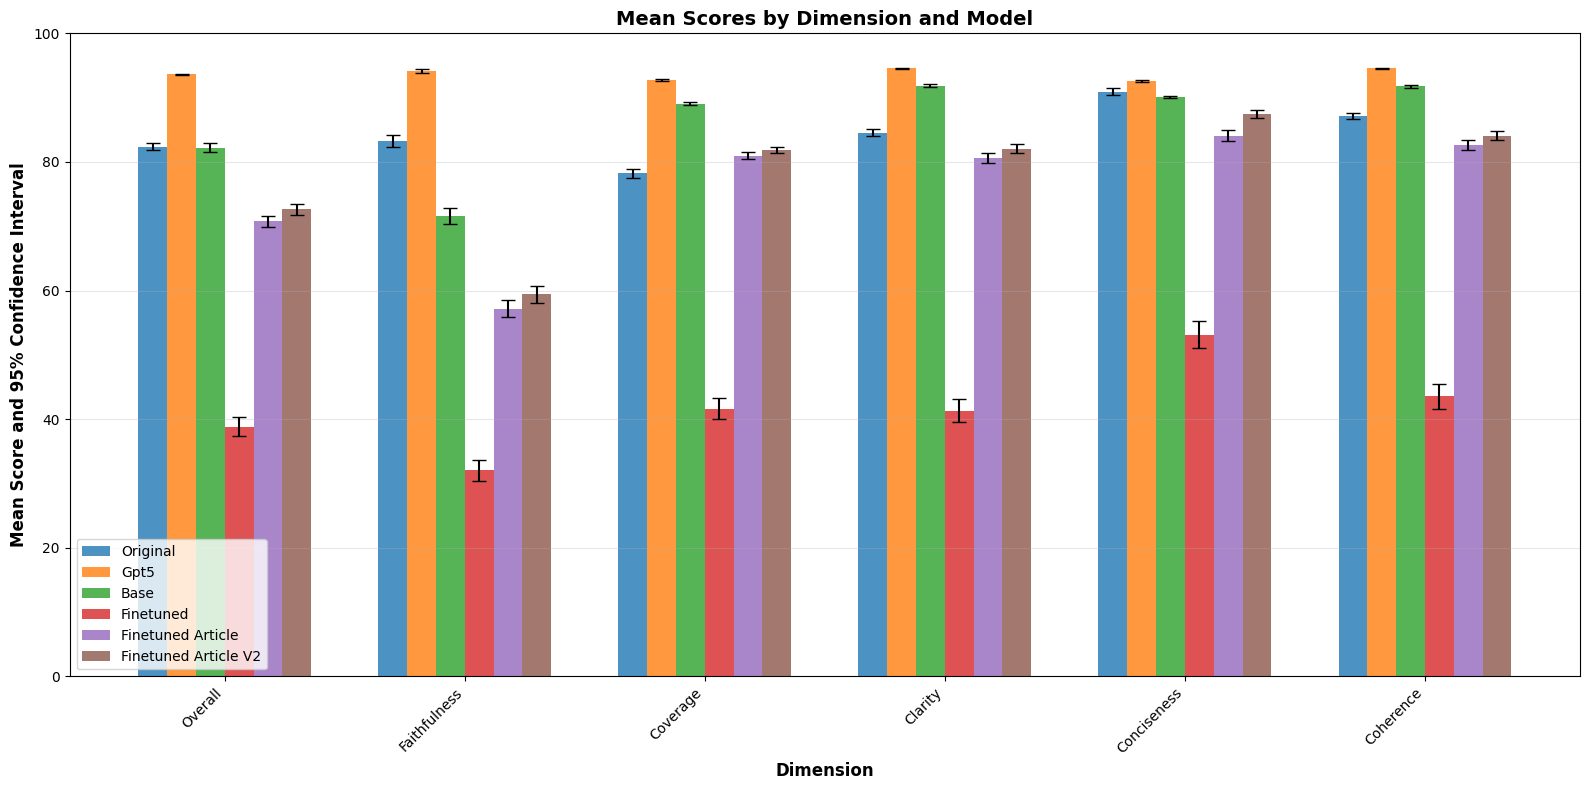

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(dimensions))
width = 0.12

for i, model in enumerate(models):
    means = []
    ci_errors = []  # 95% confidence interval half-widths
    for dim in dimensions:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna()
            n = len(scores)
            if n > 0:
                mean = scores.mean()
                std = scores.std()
                # Calculate 95% confidence interval
                # Standard error
                se = std / np.sqrt(n)
                # t-critical value for 95% CI (two-tailed, df = n-1)
                if n > 1:
                    t_critical = stats.t.ppf(0.975, df=n-1)  # 0.975 for 95% CI (two-tailed)
                    ci_half_width = t_critical * se
                else:
                    ci_half_width = 0
                means.append(mean)
                ci_errors.append(ci_half_width)
            else:
                means.append(0)
                ci_errors.append(0)
        else:
            means.append(0)
            ci_errors.append(0)
    
    offset = (i - 2.5) * width
    # Format label: replace underscores with spaces and capitalize each word
    label = ' '.join(word.capitalize() for word in model.split('_'))
    ax.bar(x + offset, means, width, label=label, 
           yerr=ci_errors, capsize=5, alpha=0.8)

ax.set_xlabel('Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Score and 95% Confidence Interval', fontsize=12, fontweight='bold')
ax.set_title('Mean Scores by Dimension and Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dimensions, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()


# Heatmap of mean scores


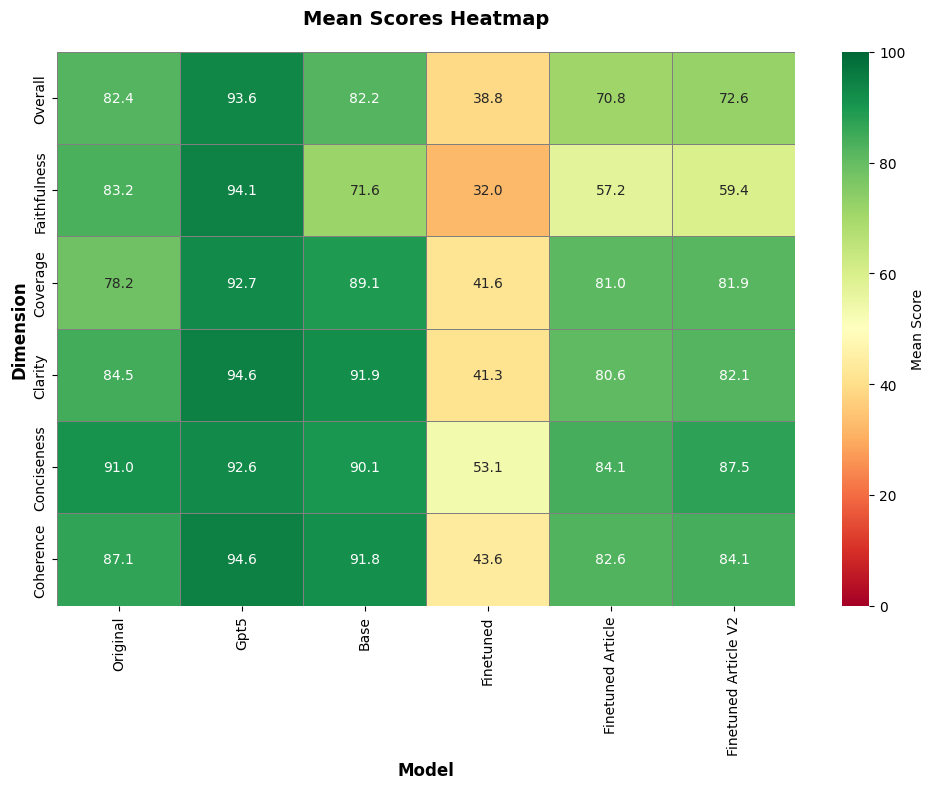

In [11]:
heatmap_data = []
for dim in dimensions:
    row = []
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            mean_score = comparison_df[col].mean()
            row.append(mean_score)
        else:
            row.append(np.nan)
    heatmap_data.append(row)

# Format column names: replace underscores with spaces and capitalize each word
heatmap_df = pd.DataFrame(heatmap_data, index=dimensions, 
                         columns=[' '.join(word.capitalize() for word in m.split('_')) for m in models])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Mean Score'}, 
            linewidths=0.5, linecolor='gray')
plt.title('Mean Scores Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Dimension', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# Review some examples

In [12]:
from utils import (
    display_message,
    load_conversations,
)

base_path = "/Users/ryanarman/code/lab/arxiv_abstract/data/qwen3_4b_test_2795.jsonl"
fine_tuned_path = "/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_results_2801.jsonl"
test_path =  "/Users/ryanarman/code/lab/arxiv_abstract/data/arxiv_summarization_test_filtered_10k.jsonl"

test_conversations = load_conversations(test_path)
base_conversations = load_conversations(base_path)
fine_tuned_conversations = load_conversations(fine_tuned_path)

ind = 0
print("="*80)
print("USER MESSAGE (original abstract):")
print("="*80)
display_message(test_conversations[ind], "assistant")
print("="*80)
print("ASSISTANT MESSAGE (baseline summary):")
print("="*80)
display_message(base_conversations[ind], "assistant")
print("="*80)
print("ASSISTANT MESSAGE (fine-tuned summary):")
print("="*80)
display_message(fine_tuned_conversations[ind], "assistant")



USER MESSAGE (original abstract):
Role: ASSISTANT
Characters: 543 | Words: 90 | Lines: 4



ASSISTANT MESSAGE (baseline summary):
Role: ASSISTANT
Characters: 1,343 | Words: 191 | Lines: 3



ASSISTANT MESSAGE (fine-tuned summary):
Role: ASSISTANT
Characters: 758 | Words: 134 | Lines: 6

